#Get data from Dexcom share

In [1]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##Dev functions to fetch CGM glucose values

In [17]:
import json
import requests
import pandas as pd
import datetime

DEFAULTS = {'applicationid': 'd89443d2-327c-4a6f-89e5-496bbb0317db',
        'agent': "Dexcom Share/3.0.2.11 CFNetwork/711.2.23 Darwin/14.0.0",
        'login_url': 'https://share1.dexcom.com/ShareWebServices/Services/General/LoginPublisherAccountByName',
        'latest_url': 'https://share1.dexcom.com/ShareWebServices/Services/Publisher/ReadPublisherLatestGlucoseValues',
        'accept': 'application/json',
        'content-type': 'application/json'}

#DIRECTIONS = {'NONE': 0, 'DoubleUp': 1, 'SingleUp': 2, 'FortyFiveUp': 3,
#              'Flat': 4, 'FortyFiveDown': 5, 'SingleDown': 6, 'DoubleDown': 7,
#              'NOT COMPUTABLE': 8, 'RATE OUT OF RANGE': 9}

def authorize(account_name, account_password):
    """
    Login to server
    
    Returns
    -------
    sessionid: str
        Session ID from the server
    """
    url = DEFAULTS['login_url']
    body = {'password': account_password, 'applicationId': DEFAULTS['applicationid'], 'accountName': account_name}
    headers = {'User-Agent': DEFAULTS['agent'], 'Content-Type': DEFAULTS['content-type'],
               'Accept': DEFAULTS['accept']}
    
    response = requests.post(url, headers=headers, json=body)
    
    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "HTTPError:", e.message
        pass
    
    return response.content[1:-1]

def fetch(sessionid, minutes=1440, maxcount=1):
    """
    Get data from server
    """
    url = DEFAULTS['latest_url']
    url += '?sessionID={:}&minutes={:}&maxCount={:}'\
        .format(sessionid, minutes, maxcount)
    headers = {'User-Agent': DEFAULTS['agent'],
                'Content-Type': DEFAULTS['content-type'],
                'Content-Length': 0, 'Accept': DEFAULTS['accept']}
    
    response = requests.post(url, headers=headers)
    
    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "HTTPError:", e.message
        pass

    return json.loads(response.content)

def dex2pandas(dex):
    """
    Convert Dexcom server entries to a Pandas dataframe
    """
    date = [datetime.datetime.fromtimestamp(float(d['WT'][6:-2])/1000.) for d in dex]
    value = [d['Value'] for d in dex]
    trend = [d['Trend'] for d in dex]
    
    df = pd.DataFrame({'datetime': date, 'value': value, 'trend': trend})
    df['device'] = 'share2'
    df['type'] = 'cgm'
    
    return df

,trend,value
count,283.000000,283.000000
mean,3.964664,146.568905
std,0.250153,25.700637
min,3.000000,86.000000
25%,4.000000,127.000000
50%,4.000000,154.000000
75%,4.000000,169.000000
max,5.000000,181.000000


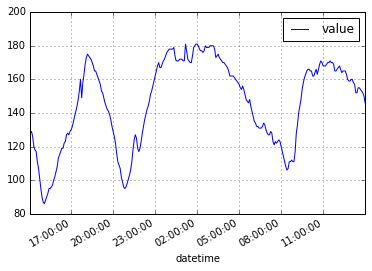

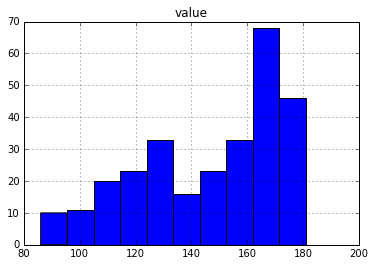

In [18]:
# user options (set here or set environment variables before launching notebook)
SHARE_ACCOUNT_NAME=os.environ['SHARE_ACCOUNT_NAME']
SHARE_PASSWORD=os.environ['SHARE_PASSWORD']

sid = authorize(SHARE_ACCOUNT_NAME, SHARE_PASSWORD)

dex = fetch(sid, maxcount=1000)

df = dex2pandas(dex)

df.plot(x='datetime', y='value')
df.hist(column='value')

df.describe()